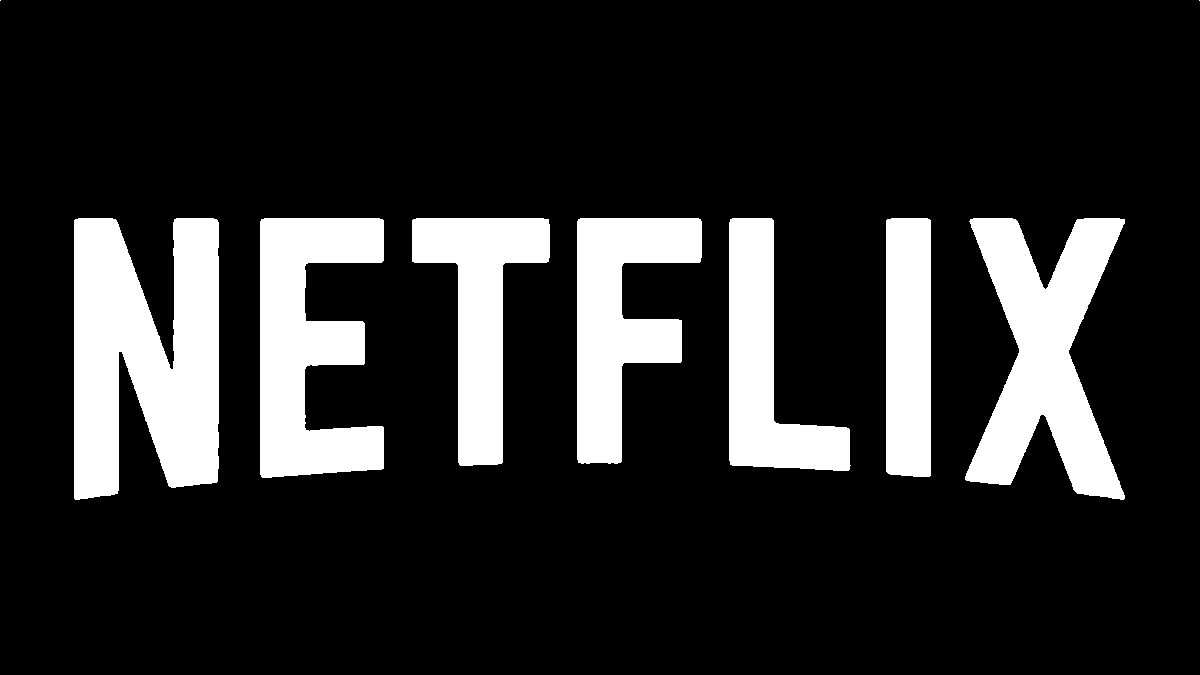

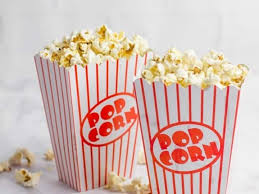

In [1]:
import statistics
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import plotly.graph_objs as go
import plotly.express as px

from ast import literal_eval
from plotly.offline import iplot
from wordcloud.wordcloud import WordCloud

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

from timeit import default_timer
st = default_timer()




In [2]:
movies = pd.read_csv(r'movies.csv')

ratings = pd.read_csv(r"C:\Users\Lenovo\OneDrive\Desktop\ratings.csv")
ratings = ratings[ratings['movieId'].isin(movies.index.values)]

In [3]:
# Organise a bit and store into feather-format

movies.sort_values(by='movieId', inplace=True)
movies.reset_index(inplace=True, drop=True)
ratings.sort_values(by='movieId', inplace=True)
ratings.reset_index(inplace=True, drop=True)

print(movies.dtypes)
print(ratings.dtypes)

movieId     int64
title      object
genres     object
dtype: object
userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object


In [4]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [5]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77939 entries, 0 to 77938
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   userId     77939 non-null  int64  
 1   movieId    77939 non-null  int64  
 2   rating     77939 non-null  float64
 3   timestamp  77939 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 2.4 MB


In [6]:
movies.describe()

,movieId
count,9742.000000
mean,42200.353623
std,52160.494854
min,1.000000
25%,3248.250000
50%,7300.000000
75%,76232.000000
max,193609.000000


In [7]:
ratings.describe()

,userId,movieId,rating,timestamp
count,77939.000000,77939.000000,77939.000000,7.793900e+04
mean,324.768614,2645.132565,3.503188,1.149176e+09
std,182.800724,2249.376208,1.048929,2.051429e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,805.000000,3.000000,9.749190e+08
50%,325.000000,2054.000000,3.500000,1.113188e+09
75%,474.000000,3949.000000,4.000000,1.307416e+09
max,610.000000,9018.000000,5.000000,1.537799e+09


In [8]:
data = pd.merge(movies, ratings, on = 'movieId', how = 'inner')
data.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,490,3.5,1328229305
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,178,4.0,1164354911
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,179,4.0,852114051
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,182,4.0,1063289621


In [9]:
data.shape

(77939, 6)

In [10]:
data_1=data.drop(['timestamp'], axis = 1)
data_1

,movieId,title,genres,userId,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,490,3.5
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,178,4.0
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,179,4.0
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,182,4.0
...,...,...,...,...,...
77934,9010,Love Me If You Dare (Jeux d'enfants) (2003),Drama|Romance,474,3.0
77935,9010,Love Me If You Dare (Jeux d'enfants) (2003),Drama|Romance,105,4.5
77936,9018,Control Room (2004),Documentary|War,221,5.0
77937,9018,Control Room (2004),Documentary|War,462,4.0


In [11]:
# Now, We have to Groupby the Dataset Based on the Movie Title

data_1 = pd.pivot_table(data_1, index = ['title','genres'], aggfunc = 'mean')
data_1.reset_index(level=['title','genres'], inplace = True)
data_1.head()

,title,genres,movieId,rating,userId
0,'Til There Was You (1997),Drama|Romance,779,4.000000,229.000000
1,"'burbs, The (1989)",Comedy,2072,3.176471,321.882353
2,'night Mother (1986),Drama,3112,3.000000,474.000000
3,*batteries not included (1987),Children|Comedy|Fantasy|Sci-Fi,8169,3.285714,497.285714
4,...All the Marbles (1981),Comedy|Drama,5706,2.000000,377.000000


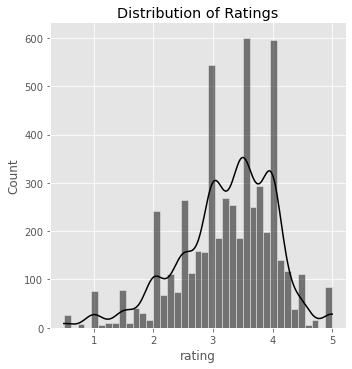

In [12]:
# lets check the Distribution of Ratings across the Movies
sns.displot(x=data_1['rating'], color = 'black',kde=True,height=5)
plt.title('Distribution of Ratings')
plt.show()

In [13]:
# Lets Extract Year of Release from the Movie Title
data_1['y'] = data_1['title'].str.split(' ')
data_1['year'] = data_1['y'].apply(lambda x: x[-1])
data_1.head()

,title,genres,movieId,rating,userId,y,year
0,'Til There Was You (1997),Drama|Romance,779,4.000000,229.000000,"['Til, There, Was, You, (1997)]",(1997)
1,"'burbs, The (1989)",Comedy,2072,3.176471,321.882353,"['burbs,, The, (1989)]",(1989)
2,'night Mother (1986),Drama,3112,3.000000,474.000000,"['night, Mother, (1986)]",(1986)
3,*batteries not included (1987),Children|Comedy|Fantasy|Sci-Fi,8169,3.285714,497.285714,"[*batteries, not, included, (1987)]",(1987)
4,...All the Marbles (1981),Comedy|Drama,5706,2.000000,377.000000,"[...All, the, Marbles, (1981)]",(1981)


In [14]:
# lets drop the unnecessary 'y' column from the dataset
data_1 = data_1.drop(['y'], axis = 1)
data_1.head()

,title,genres,movieId,rating,userId,year
0,'Til There Was You (1997),Drama|Romance,779,4.000000,229.000000,(1997)
1,"'burbs, The (1989)",Comedy,2072,3.176471,321.882353,(1989)
2,'night Mother (1986),Drama,3112,3.000000,474.000000,(1986)
3,*batteries not included (1987),Children|Comedy|Fantasy|Sci-Fi,8169,3.285714,497.285714,(1987)
4,...All the Marbles (1981),Comedy|Drama,5706,2.000000,377.000000,(1981)


In [15]:
# lets remove the Opening and Closing Brackets from the String
data_1['year'] = data_1['year'].str.strip(')')
data_1['year'] = data_1['year'].str.strip('(')
data_1.head()

,title,genres,movieId,rating,userId,year
0,'Til There Was You (1997),Drama|Romance,779,4.000000,229.000000,1997
1,"'burbs, The (1989)",Comedy,2072,3.176471,321.882353,1989
2,'night Mother (1986),Drama,3112,3.000000,474.000000,1986
3,*batteries not included (1987),Children|Comedy|Fantasy|Sci-Fi,8169,3.285714,497.285714,1987
4,...All the Marbles (1981),Comedy|Drama,5706,2.000000,377.000000,1981


In [16]:
data_1['year'].value_counts()[:5]

2002    277
2001    271
1996    256
2000    253
1995    241
Name: year, dtype: int64

In [17]:
data_1['year'].unique()


array(['1997', '1989', '1986', '1987', '1981', '1979', '1994', '1999',
       '2000', '1996', '1961', '1965', '2002', '1957', '1960', '2004',
       '1992', '2001', '1972', '1988', '1984', '2003', '1998', '1954',
       '1968', '1985', '1995', '1977', '1935', '1959', '1933', '1982',
       '1953', '1958', '1963', '1948', '1971', '1951', '1949', '1993',
       '1991', '1990', '1938', '1966', '1936', '1980', '1970', '1974',
       '1950', '1930', '1955', '1976', '1983', '1973', '1964', '1956',
       '1945', '1978', '1969', '1939', '1975', '1944', '1937', '1934',
       '1947', '1952', '1942', '1940', '1967', '1925', '1946', '1962',
       '1915', '1929', '1920', '1931', '1928', '1941', '1927', '1943',
       '1919', '1932', '1926', '1917', '1916', '1921', '1924', '1922',
       '1923'], dtype=object)

In [18]:
# lets remove the Year from the Movie Titles
data_1['title'] = data_1['title'].str.split(' ')
data_1['title'] = data_1['title'].apply(lambda x: ' '.join(x[:-1]))
# lets check the head of the dataset again
data_1.head()

,title,genres,movieId,rating,userId,year
0,'Til There Was You,Drama|Romance,779,4.000000,229.000000,1997
1,"'burbs, The",Comedy,2072,3.176471,321.882353,1989
2,'night Mother,Drama,3112,3.000000,474.000000,1986
3,*batteries not included,Children|Comedy|Fantasy|Sci-Fi,8169,3.285714,497.285714,1987
4,...All the Marbles,Comedy|Drama,5706,2.000000,377.000000,1981


In [19]:
data_1.dtypes

title       object
genres      object
movieId      int64
rating     float64
userId     float64
year        object
dtype: object

In [20]:
# lets convert the year column into Integer data type

data_1['year'] = data_1['year'].astype(int)
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5390 entries, 0 to 5389
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   title    5390 non-null   object 
 1   genres   5390 non-null   object 
 2   movieId  5390 non-null   int64  
 3   rating   5390 non-null   float64
 4   userId   5390 non-null   float64
 5   year     5390 non-null   int32  
dtypes: float64(2), int32(1), int64(1), object(2)
memory usage: 231.7+ KB


In [21]:
# Lets check the Latest Movies - the Last Year mentioned in the Dataset is 2004
data_1[data_1['year'] == data_1['year'].max()][['title','rating']].sort_values(by = 'rating',
                ascending = False).head(10).reset_index(drop = True).style.background_gradient(cmap = 'Wistia')

,title,rating
0,Raise Your Voice,5.000000
1,Control Room,4.333333
2,P.S.,4.250000
3,Eternal Sunshine of the Spotless Mind,4.160305
4,Shaun of the Dead,4.006494
5,Lightning in a Bottle,4.000000
6,Guerrilla: The Taking of Patty Hearst,4.000000
7,Agent Cody Banks 2: Destination London,4.000000
8,We Don't Live Here Anymore,4.000000
9,De-Lovely,4.000000


In [22]:
# lets Check the Number of Movies that got 5 Star Reviews and Less than 1 Star Reviews

print("The Number of Movies that received 5 Star Reviews :", data_1[data_1['rating'] == 5]['title'].count())
print("Percentage of Movies Getting 5 Star Reviews : {0:.2f}%".format((data_1[data_1['rating'] == 5]['title'].count())/
                                                                      (data_1.shape[0])))

The Number of Movies that received 5 Star Reviews : 84
Percentage of Movies Getting 5 Star Reviews : 0.02%


In [23]:
print("\nThe Number of Movies that received less than 1 Star Reviews :", data_1[data_1['rating'] <= 1]['title'].count())
print("The Percentage of Movies Getting Less than 1 Star Reviews : {0:.2f}%".format((
    data_1[data_1['rating'] <= 1]['title'].count())/(data_1.shape[0])))


The Number of Movies that received less than 1 Star Reviews : 110
The Percentage of Movies Getting Less than 1 Star Reviews : 0.02%


In [24]:
#To find out how many people have rated the movies as 1, 2, 3,4,5 stars ratings to the movies
stars=data_1.groupby('rating')['rating'].agg(['count'])
stars.head()

,count
rating,
0.500000,26
0.750000,5
0.800000,1
0.833333,2
1.000000,76


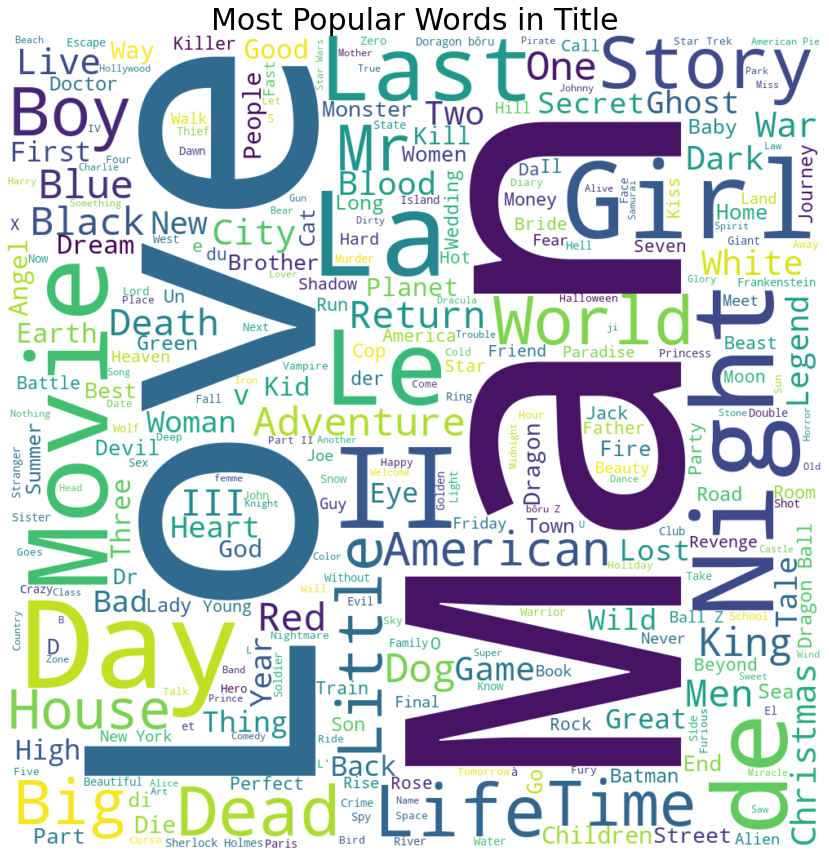

In [25]:
plt.figure(figsize=[15,15])


wordcloud = WordCloud(stopwords=None,background_color = 'white', 
                      width = 1000,  
                      height = 1000, 
                      max_words =300,
                     ).generate(' '.join(movies['title']))

wordcloud.recolor(color_func=None)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Popular Words in Title',fontsize = 30)
plt.show()

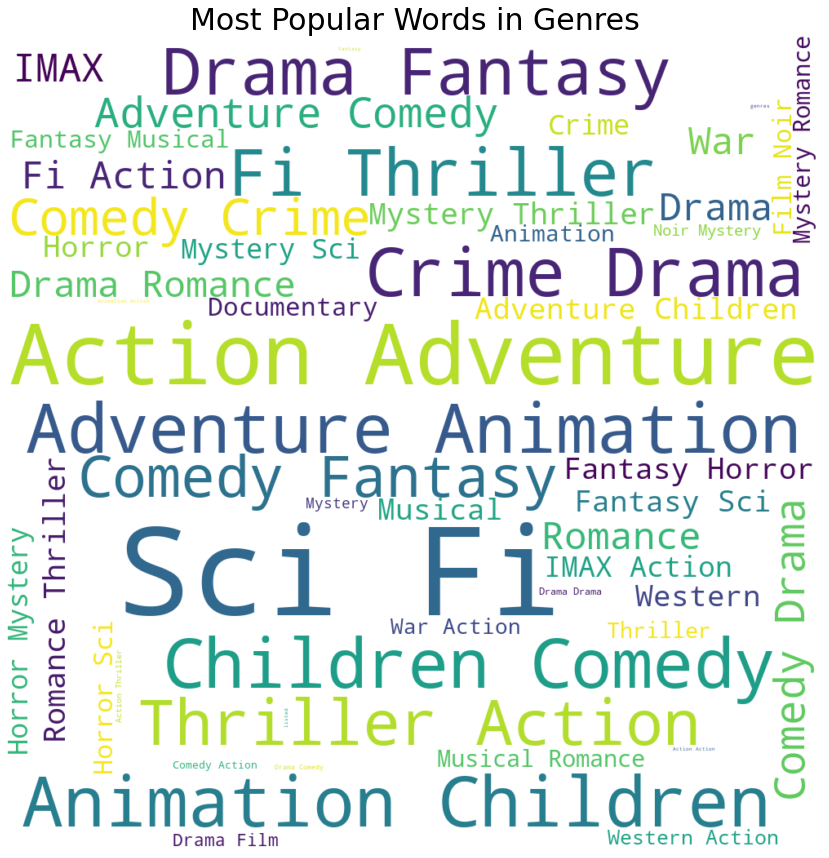

In [26]:
plt.figure(figsize=[15,15])


wordcloud = WordCloud(stopwords=None,background_color = 'white', 
                      width = 1000,  
                      height = 1000, 
                      max_words =300,
                     ).generate(' '.join(movies['genres'].unique()))

wordcloud.recolor(color_func=None)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Popular Words in Genres',fontsize = 30)
plt.show()

In [27]:

# lets create an Interactive Function to get the List of Best Movies from Each Genre
# for Interactive Analysis
from ipywidgets import interact
@interact
def genre(Genre = ['Action', 'Adventure', 'Animation','Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
       'Film-Noir', 'Horror', 'IMAX','Listed', 'Musical', 'Mystery', 'Romance','Sci-Fi', 'Thriller', 'War', 'Western'],
          
          year = sorted(data_1['year'].unique(), reverse=True)):
    x = data_1['genres'].str.split('|')
    d = data_1.drop(['genres'], axis = 1)
    x = pd.concat([d, x], axis = 1)
    x = x.explode('genres')
    x= x[(x['genres'] == Genre)& 
         (x['year'] >= year)][['title', 'rating', 'year']].sort_values(by = ['rating','year'],
                            ascending = [False,True]).reset_index(drop = True).head(10)
    return x

interactive(children=(Dropdown(description='Genre', options=('Action', 'Adventure', 'Animation', 'Children', '…

In [28]:
from mlxtend.preprocessing import TransactionEncoder

# lets split all the Genres into Transactions
genres = data_1['genres'].str.split('|')
te = TransactionEncoder()
genres = te.fit_transform(genres)
genres = pd.DataFrame(genres, columns = te.columns_)
genres = genres.astype('int')
genres.insert(0, 'title', data_1['title'])

genres.head()

,title,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,'Til There Was You,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
1,"'burbs, The",0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,'night Mother,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,*batteries not included,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0
4,...All the Marbles,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [29]:
genres.rename(columns = genres.iloc[0])


,'Til There Was You,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
0,'Til There Was You,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
1,"'burbs, The",0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,'night Mother,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,*batteries not included,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0
4,...All the Marbles,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5385,Zulu,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
5386,eXistenZ,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
5387,xXx,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
5388,¡Three Amigos!,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [30]:
# lets Transpose the Dataset
genres = genres.transpose()
genres = genres.rename(columns = genres.iloc[0])
genres = genres.drop(genres.index[0])
genres = genres.astype(int)
# lets check the head of genres
genres.head()

,'Til There Was You,"'burbs, The",'night Mother,*batteries not included,...All the Marbles,...And Justice for All,1-900 (06),10,10 Things I Hate About You,100 Girls,...,Zero de conduite (Zero for Conduct) (Zéro de conduite: Jeunes diables au collège),Zeus and Roxanne,Zombie (a.k.a. Zombie 2: The Dead Are Among Us) (Zombi 2),Zone 39,Zoolander,Zulu,eXistenZ,xXx,¡Three Amigos!,À nous la liberté (Freedom for Us)
Action,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,1,0,0
Adventure,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Animation,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Children,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
Comedy,0,1,0,1,1,0,0,1,1,1,...,1,0,0,0,1,0,0,0,1,1


In [31]:
# making a recommendation engine for getting similar movies
sorted(data_1['year'].unique(), reverse=True)
@interact
def recommendation_movie(movie = sorted(genres.columns.unique(), reverse=False)):    
    similar_movies = genres.corrwith(genres[movie])
    similar_movies = similar_movies.sort_values(ascending=False)
    similar_movies=similar_movies.dropna()
    similar_movies=similar_movies.reset_index()
    similar_movies.columns = ['Movie', 'Score']
    similar_movies=similar_movies[similar_movies['Movie']!=movie]
    similar_movies.Score=round((similar_movies.Score*100),2)
    if len(similar_movies)== 0:
        return print('\n\t\t No Recommendation!!!')
    else:
        return similar_movies.head()

interactive(children=(Dropdown(description='movie', options=("'Til There Was You", "'burbs, The", "'night Moth…

In [32]:
f=['count','mean']

In [33]:
df_movie_summary=data_1.groupby('movieId')['rating'].agg(f)
df_movie_summary

,count,mean
movieId,,
1,1,3.920930
2,1,3.431818
3,1,3.259615
4,1,2.357143
5,1,3.071429
...,...,...
9004,1,2.000000
9005,1,2.000000
9008,1,2.500000


In [34]:
#now we will store all the movie_id indexes in a variable dataset_movie_summary.index and convert the datatype to int
df_movie_summary.index=df_movie_summary.index.map(int)
movie_benchmark=round(df_movie_summary['count'].quantile(0.7),0)
drop_movie_list=df_movie_summary[df_movie_summary['count']<movie_benchmark].index
print('Movie minimum times of review: {}'.format(movie_benchmark))

Movie minimum times of review: 1.0


In [35]:
#now we will remove all the users that are in-active
df_user_summary=data_1.groupby('userId')['rating'].agg(f)
df_user_summary

,count,mean
userId,,
1.0,1,4.000000
3.0,4,4.750000
4.0,4,3.500000
6.0,11,3.000000
9.0,2,1.500000
...,...,...
606.0,82,3.682927
607.0,2,4.000000
608.0,3,3.833333


In [36]:
df_user_summary.index=df_user_summary.index.map(int)
user_benchmark=round(df_user_summary['count'].quantile(0.7),0)
drop_user_list=df_user_summary[df_user_summary['count']<user_benchmark].index
print(f'User minimum times of review: {user_benchmark}')


User minimum times of review: 1.0


In [37]:
#we will remove all the customers and movies that are below the benchmark 
print('The original dataframe has: ', data_1.shape, 'shape')

data_1=data_1[~data_1['movieId'].isin(drop_movie_list)]
data_1=data_1[~data_1['userId'].isin(drop_user_list)]
print('After the triming, the shape is: {}'.format(data_1.shape))

The original dataframe has:  (5390, 6) shape
After the triming, the shape is: (5390, 6)


In [38]:
data_1.head()

,title,genres,movieId,rating,userId,year
0,'Til There Was You,Drama|Romance,779,4.000000,229.000000,1997
1,"'burbs, The",Comedy,2072,3.176471,321.882353,1989
2,'night Mother,Drama,3112,3.000000,474.000000,1986
3,*batteries not included,Children|Comedy|Fantasy|Sci-Fi,8169,3.285714,497.285714,1987
4,...All the Marbles,Comedy|Drama,5706,2.000000,377.000000,1981


In [39]:
#now we will prepare the dataset for SVD and it takes the matrix as the input
# so for input, we will convert the dataset into sparse matrix

df_p = pd.pivot_table(data_1, values='rating', index='userId', columns='movieId')
print(df_p.shape)

(3219, 5390)


In [40]:
df_p.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,8984,8985,8987,8989,8998,9004,9005,9008,9010,9018
userId,,,,,,,,,,,,,,,,,,,,,
1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:


# Load Reader library
reader = Reader()
#To load a dataset from a pandas dataframe, you will need the load_from_df() method
# get just top 100K rows for faster run time
data = Dataset.load_from_df(data_1[['userId', 'movieId', 'rating']], reader=reader)

# Use the SVD algorithm.
svd = SVD()

# Compute the RMSE of the SVD algorithm
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=3, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.7599  0.7881  0.7498  0.7659  0.0162  
MAE (testset)     0.5993  0.6166  0.5855  0.6004  0.0127  
Fit time          0.44    0.42    0.40    0.42    0.01    
Test time         0.02    0.02    0.02    0.02    0.00    


{'test_rmse': array([0.75991944, 0.78808638, 0.7497762 ]),
 'test_mae': array([0.59927943, 0.6165563 , 0.58545919]),
 'fit_time': (0.4360322952270508, 0.422027587890625, 0.40316319465637207),
 'test_time': (0.021816730499267578,
  0.021001815795898438,
  0.020000934600830078)}

In [42]:
data_1.head()

,title,genres,movieId,rating,userId,year
0,'Til There Was You,Drama|Romance,779,4.000000,229.000000,1997
1,"'burbs, The",Comedy,2072,3.176471,321.882353,1989
2,'night Mother,Drama,3112,3.000000,474.000000,1986
3,*batteries not included,Children|Comedy|Fantasy|Sci-Fi,8169,3.285714,497.285714,1987
4,...All the Marbles,Comedy|Drama,5706,2.000000,377.000000,1981


In [43]:
#so first we take user 377 and we try to recommend some movies based on the past data
user_377=data_1[(data_1['userId'] ==377)& (data_1['rating']==5)]
user_377

,title,genres,movieId,rating,userId,year
31,20 Million Miles to Earth,Sci-Fi,5468,5.0,377.0,1957
220,"American Friend, The (Amerikanische Freund, Der)",Crime|Drama|Mystery|Thriller,6021,5.0,377.0,1977


In [44]:
# Create a shallow copy for the movies dataset
user_377 = data_1.copy()

user_377 = user_377.reset_index()

#To remove all the movies rated less often 
user_377 = user_377[~user_377['movieId'].isin(drop_movie_list)]


# getting full dataset
data = Dataset.load_from_df(data_1[['userId', 'movieId', 'rating']], reader)

#create a training set for svd
trainset = data.build_full_trainset()
svd.fit(trainset)

#Predict the ratings for user_377
user_377['Estimate_Score'] = user_377['movieId'].apply(lambda x: svd.predict(377, x).est)

#Drop extra columns from the user_377 data frame
user_377 = user_377.drop('movieId', axis = 1)
user_377 = user_377.drop('userId', axis = 1)

# Sort predicted ratings for user_377 in descending order
user_377 = user_377.sort_values('Estimate_Score', ascending=False)

#Print top 10 recommendations
print(user_377.head(10))

      index                                             title  \
4778   4778                                       The Big Bus   
220     220  American Friend, The (Amerikanische Freund, Der)   
3124   3124                                           Memento   
4564   4564                                        Stay Tuned   
193     193                      All the Vermeers in New York   
4180   4180                                    Sandpiper, The   
3602   3602        Oscar and Lucinda (a.k.a. Oscar & Lucinda)   
2692   2692                                         Knock Off   
4604   4604                                        Straw Dogs   
150     150                                           Aladdin   

                                           genres    rating  year  \
4778                                Action|Comedy  5.000000  1976   
220                  Crime|Drama|Mystery|Thriller  5.000000  1977   
3124                             Mystery|Thriller  4.122642  2000   
4564    